# Jazli Muhammad Khairi Leong
# Student Number: 1007793595
# UTORid: muham283

## Provide posterior inference for a column of data with a `PyMC` normal-gamma specification

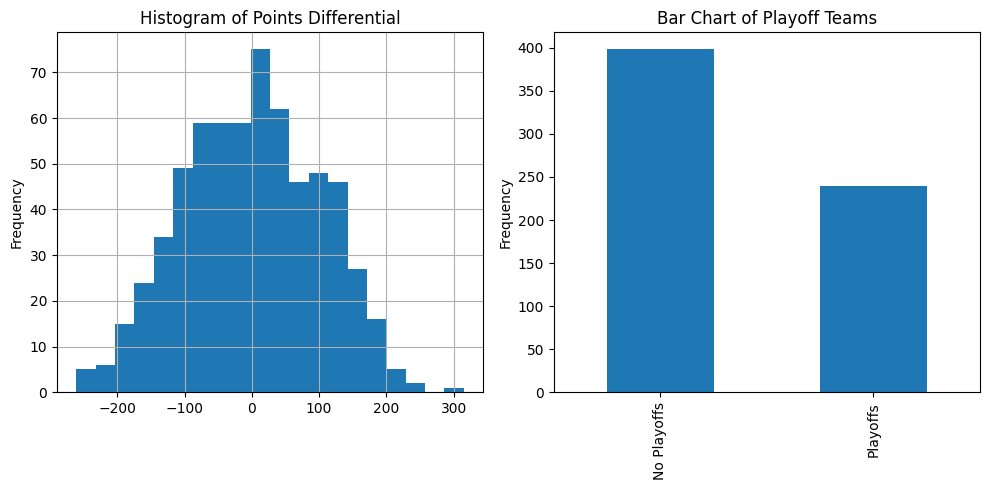

In [153]:
import pandas as pd
import pymc as pm
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('nfl_standings.csv')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot normal data
df['points_differential'].hist(bins=20)
plt.title('Histogram of Points Differential')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df['playoffs'].value_counts().plot(kind='bar') # discrete data
plt.title('Bar Chart of Playoff Teams')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [154]:
theta_0 = 0; tau = 1; alpha = 2; beta = 1/2

normal_gamma_toy_model = pm.Model()
with normal_gamma_toy_model:
    theta = pm.Normal("theta", mu=0, sigma=1)
    phi = pm.Gamma("phi", alpha=1, beta=1)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=df['points_differential'])


In [182]:
# Sample from the normal-gamma Posterior
with normal_gamma_toy_model:
    HMC_sample = pm.sample()


HMC Split-Rhats {'theta': 1.0009, 'phi': 1.0008}


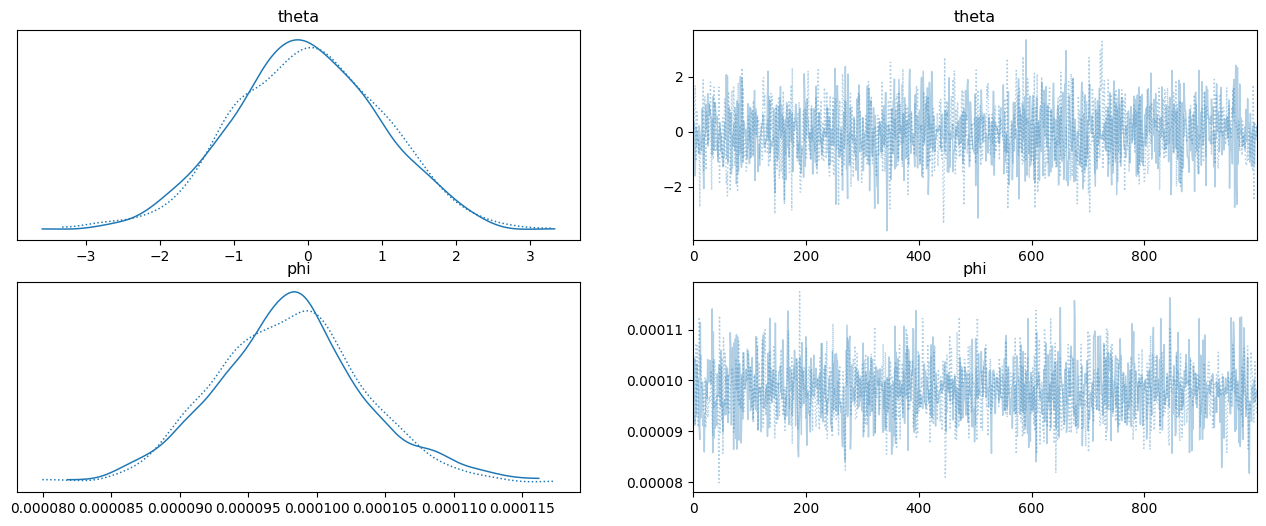

In [183]:
import arviz as az;
fig,ax = plt.subplots(2,2, figsize=(16,6))
az.plot_trace(HMC_sample, axes=ax[:2,:2])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(HMC_sample).items()})


### Credible Interval for normal-gamma posterior

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

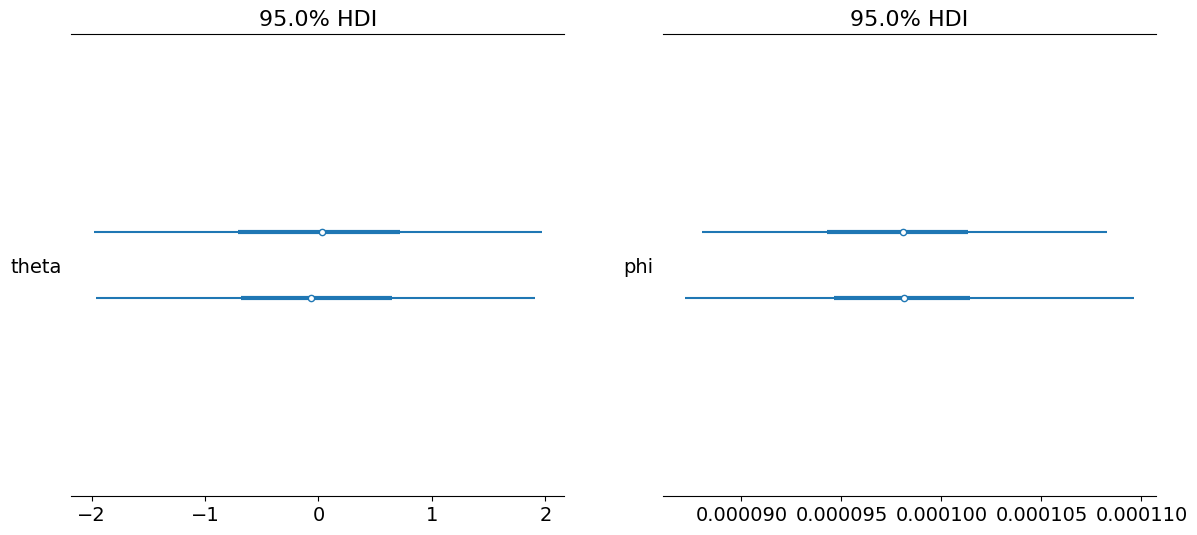

In [184]:
fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(HMC_sample, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(HMC_sample, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1])

## Find a different column of data for which a normal-gamma specification isn't justified.

Text(0.5, 1.0, 'Bar Chart of Playoff Teams')

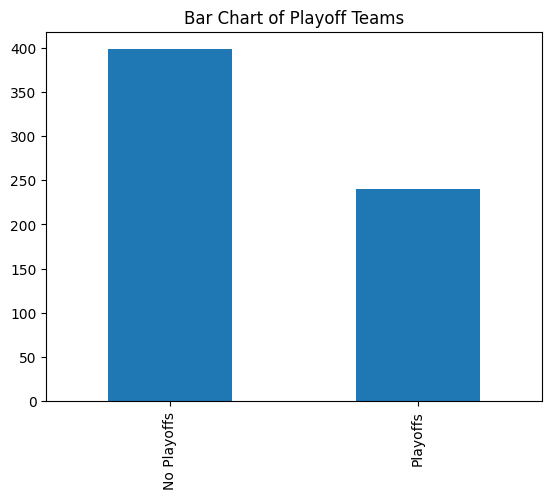

In [185]:
df['playoffs'].value_counts().plot(kind='bar')
plt.title('Bar Chart of Playoff Teams') # As shown above I've repeated the bar graph to show that the column of data is non normal-gamma

## Create a different PyMC specification that IS appropriate for this new data column

In [186]:
playoff_teams = df['playoffs'].map({'Playoffs': 1, 'No Playoffs': 0})
playoff_teams = pd.DataFrame(playoff_teams)

For this "Playoffs" column it will be used as a Bernoulli distribution since it was mapped to either 0 or 1 depending on if the team was a playoff team or not.

In [190]:
import pymc as pm
bernoulli_uniform_toy_model = pm.Model()
with bernoulli_uniform_toy_model:
    theta = pm.Uniform("theta", lower=0, upper=1)
    x_obs = pm.Bernoulli("likelihood", p=theta, observed=playoff_teams)

In [193]:
# MCMC Sample on the Bernoulli distribution
with bernoulli_uniform_toy_model:
    HMC_sample_discrete = pm.sample()

HMC Split-Rhats {'theta': 1.0006}


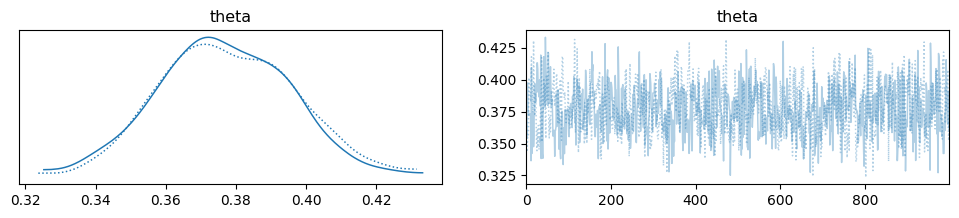

In [194]:
import arviz as az;
az.plot_trace(HMC_sample_discrete)
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(HMC_sample_discrete).items()})

### Credible Interval for discrete Bernoulli posterior

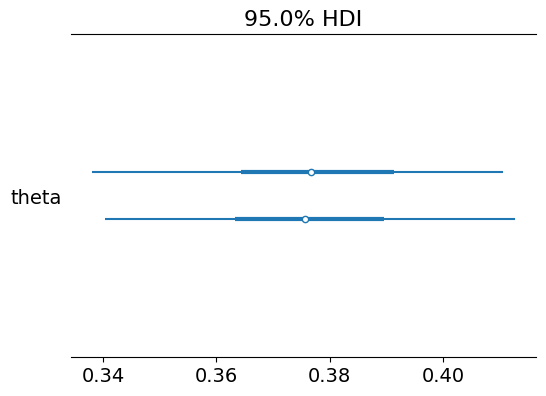

In [195]:
az.plot_forest(HMC_sample_discrete, var_names=["theta"], combined=False, hdi_prob=0.95);

## Provide posterior inference for the parameters of your new specification given the column of non-normal data using `PyMC` and provide an analysis of the MCMC chains.

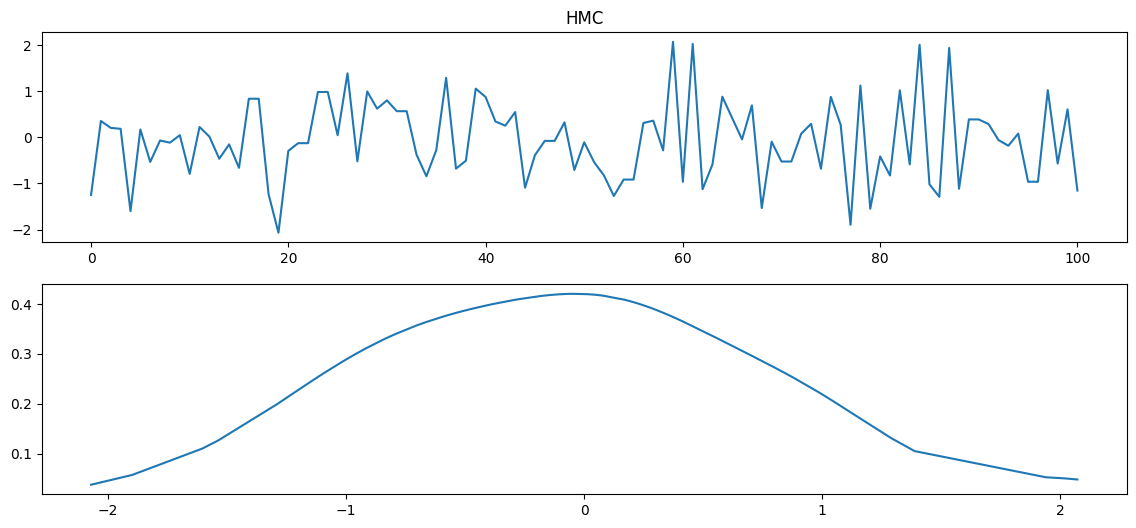

In [196]:
# For normal-gamma posterior
from scipy.stats import gaussian_kde; fig,ax = plt.subplots(2,1,figsize=(14,6))
n_mcmc_samples = 100
mcmc_chain = HMC_sample.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values;
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0].plot(mcmc_chain);
ax[1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted));
ax[0].set_title("HMC");

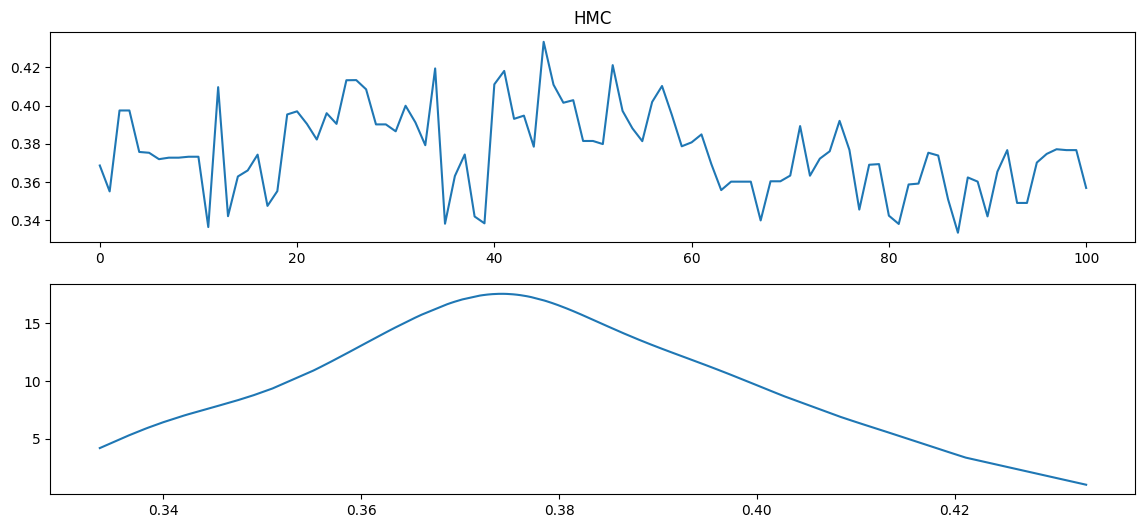

In [197]:
# For discrete Bernoulli posterior
from scipy.stats import gaussian_kde; fig,ax = plt.subplots(2,1,figsize=(14,6))
n_mcmc_samples = 100
mcmc_chain = HMC_sample_discrete.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values;
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0].plot(mcmc_chain);
ax[1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted));
ax[0].set_title("HMC");

### Checking Effective Sample Size (ESS)

#### ESS of normal-gamma posterior

In [198]:
print("MCMC Samples:", HMC_sample.posterior['theta'].values.flatten().shape[-1])
az.summary(HMC_sample, round_to=2)

MCMC Samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.01,1.01,-1.82,1.92,0.02,0.02,2212.21,1567.31,1.0
phi,0.00,0.00,0.00,0.00,0.00,0.00,2140.88,1406.38,1.0


#### ESS of Discrete Bernoulli posterior

In [203]:
print("MCMC samples:", HMC_sample_discrete.posterior['theta'].values.flatten().shape[-1])
az.summary(HMC_sample_discrete, round_to=2)

MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.38,0.02,0.34,0.41,0.0,0.0,763.36,1373.87,1.0


## Autocorrelation

#### Autocorrelation for normal-gamma posterior

Autocorrelation for HMC (MCMC) chain -0.0760163035312016


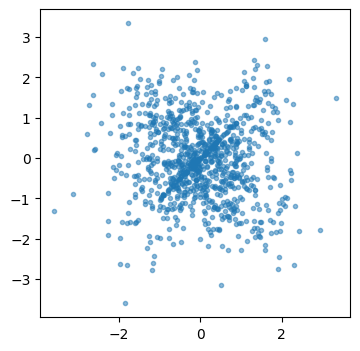

In [201]:
fig,ax = plt.subplots( figsize=(4,4))
max_mcmc_samples = 1000
mcmc_chain = HMC_sample.posterior["theta"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values;
mcmc_chain_one_step_ahead = HMC_sample.posterior["theta"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values;
plt.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

#### Autocorrelation for discrete Bernoulli posterior

Autocorrelation for HMC (MCMC) chain 0.3722777766587607


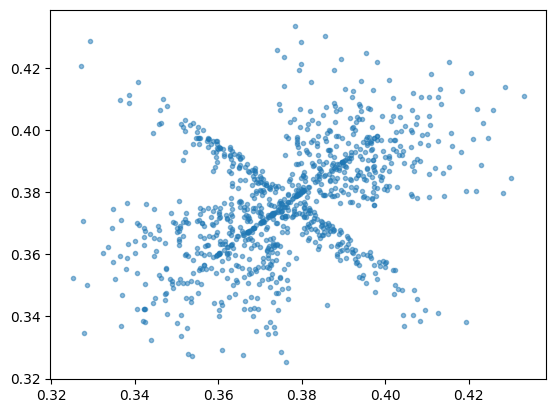

In [202]:
max_mcmc_samples = 1000
mcmc_chain = HMC_sample_discrete.posterior["theta"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values;
mcmc_chain_one_step_ahead = HMC_sample_discrete.posterior["theta"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values;
plt.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

Here we can see a large difference between the normal-gamma posterior and the Bernoulli posterior